In [1]:
!python --version

Python 3.9.12


# Overview

The purpose of the model is to build a regression model, with a low RMSE.

# Importing the required libaries

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 90)

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

from lightgbm import LGBMRegressor


from sklearn import metrics
from sklearn.metrics import mean_squared_error

# Loading the data

In [3]:
data = pd.read_csv(datasets.csv)

In [4]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# Data Overview

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [6]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [7]:
data.shape

(21613, 21)

# Dataset Description

The dataset for this project was sourced from kaggle. It contains information of  house price in China, across 21 different attributes ranging from numbers of bedrooms to the price of the house.

# Defination of Attributes
1. id - Unique identified for a house
2. date - Date house was sold
3. price - Price is prediction target
4. bedrooms - Number of Bedrooms/House
5. bathrooms - Number of bathrooms/bedrooms
6. sqft_living - Square footage of the home
7. sqft_lot - Square footage of the lot
8. floors - Total floors (levels) in house
9. waterfront - House which has a view to a waterfront
10. view - Has been viewed
11. condition - How good the condition is ( Overall )
12. grade - overall grade given to the housing unit, based on King County grading system
13. sqft_above - Square footage of house apart from basement
14. sqft_basement - Square footage of the basement
15. yr_built - Built Year
16. yr_renovated - Year when house was renovated
17. zipcode - Zipcode
18. lat - Latitude coordinate
20. long - Longitude coordinate
21. sqft_living15 - Square footage of interior housing living space for the nearest 15 neighbors
22. sqft_lot15 - Square footage of the land lots of the nearest 15 neighbors

### All columns are numericals

# Data Preparation

## Data Preparation took place in the following steps

1. The features and the Targets were separated
2. Dropping non-essential columns
3. Missing Value check
4. Duplicate Check
5. Checking data types

In [8]:
data1 = data.copy()

## Checking dataset for duplicates

In [9]:
data1 = data1.drop_duplicates()

In [10]:
if data1.duplicated().sum() > 0:
    print(f'There are/is duplicates in this dataset\nNumber: {data1.duplicated().sum()}')
else:
    print('Dataset contains no duplicates')

Dataset contains no duplicates


## Separating `Features` and `Target`
Along with the house id, date, latitude, longtitude and longtitude will also be dropped as they will obviously have no bearing on the housing price.

In [11]:
target = data['price']
data1 = data.drop(['id','date', 'lat', 'long','zipcode', 'yr_renovated', 'price'], axis=1)

##  Checking for missing values

In [12]:
if data1.isnull().sum().sum() > 0:
    print(f'There are/is {data1.isnull().sum().sum()} missing values in this dataset')
else:
    print('There are no missing values in this dataset')

There are no missing values in this dataset


## Checking Data Types

In [13]:
data1['bathrooms'] = data1['bathrooms'].round(decimals=0)
data1['bathrooms'] = pd.to_numeric(data1['bathrooms'], errors="coerce").fillna(0).astype('int64')

data1['floors'] = data1['floors'].round(decimals=0)
data1['floors'] = pd.to_numeric(data1['floors'], errors="coerce").fillna(0).astype('int64')

In [14]:
data1.dtypes

bedrooms         int64
bathrooms        int64
sqft_living      int64
sqft_lot         int64
floors           int64
waterfront       int64
view             int64
condition        int64
grade            int64
sqft_above       int64
sqft_basement    int64
yr_built         int64
sqft_living15    int64
sqft_lot15       int64
dtype: object

In [15]:
target

0        221900.0
1        538000.0
2        180000.0
3        604000.0
4        510000.0
           ...   
21608    360000.0
21609    400000.0
21610    402101.0
21611    400000.0
21612    325000.0
Name: price, Length: 21613, dtype: float64

### all in the right format

In [16]:
# creating a copy of data1
data2 = data1.copy()

# Feature Transformation

The features are check for skwedness. <br>
Features with over 0.5 rate of skwedness are considerd skwed.<br>
Log Transformation is applied on skwed

In [17]:
import scipy.stats

In [18]:
num = data2.select_dtypes(np.number)

In [19]:
skew_df = pd.DataFrame(data2.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data2[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,bedrooms,1.974163,1.974163,True
1,bathrooms,1.083830,1.083830,True
2,sqft_living,1.471453,1.471453,True
3,sqft_lot,13.059113,13.059113,True
4,floors,0.392880,0.392880,False
5,waterfront,11.384318,11.384318,True
6,view,3.395514,3.395514,True
7,condition,1.032733,1.032733,True
8,grade,0.771050,0.771050,True
9,sqft_above,1.446564,1.446564,True


In [20]:
for column in skew_df.query("Skewed == True")['Feature'].values:
    data2[column] = np.log1p(data2[column])

In [21]:
data3 = data2.copy()

# Data Scaling

## Standard Scalaer is applied to the features, to bring the features to a much closer scale.

In [22]:
scaler = StandardScaler()
scaler.fit(data3)

data3 = pd.DataFrame(scaler.transform(data3), index=data3.index, columns=data3.columns)

In [23]:
data3.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15
0,-0.311106,-1.656515,-1.123053,-0.388517,-0.964355,-0.087173,-0.320348,-0.621492,-0.527717,-0.752147,-0.797746,-0.544898,-1.035131,-0.395577
1,-0.311106,0.039362,0.709313,-0.113429,0.838327,-0.087173,-0.320348,-0.621492,-0.527717,0.672503,1.092766,-0.681079,-0.326658,-0.024606
2,-1.658401,-1.656515,-2.127474,0.244170,-0.964355,-0.087173,-0.320348,-0.621492,-1.534156,-1.749987,-0.797746,-1.293892,1.126551,0.041685
3,0.733938,1.242606,0.071368,-0.523948,-0.964355,-0.087173,-0.320348,2.265279,-0.527717,-1.025036,1.351580,-0.204446,-0.989904,-0.545895
4,-0.311106,0.039362,-0.291522,0.007910,-0.964355,-0.087173,-0.320348,-0.621492,0.360026,0.073935,-0.797746,0.544548,-0.134125,-0.046701


In [24]:
data4 = data3.copy()

# Target Transformation

### Log function is been applied to the target, to make the target looks like it came from a normal distrubution.

C:\Users\adeju\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\adeju\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


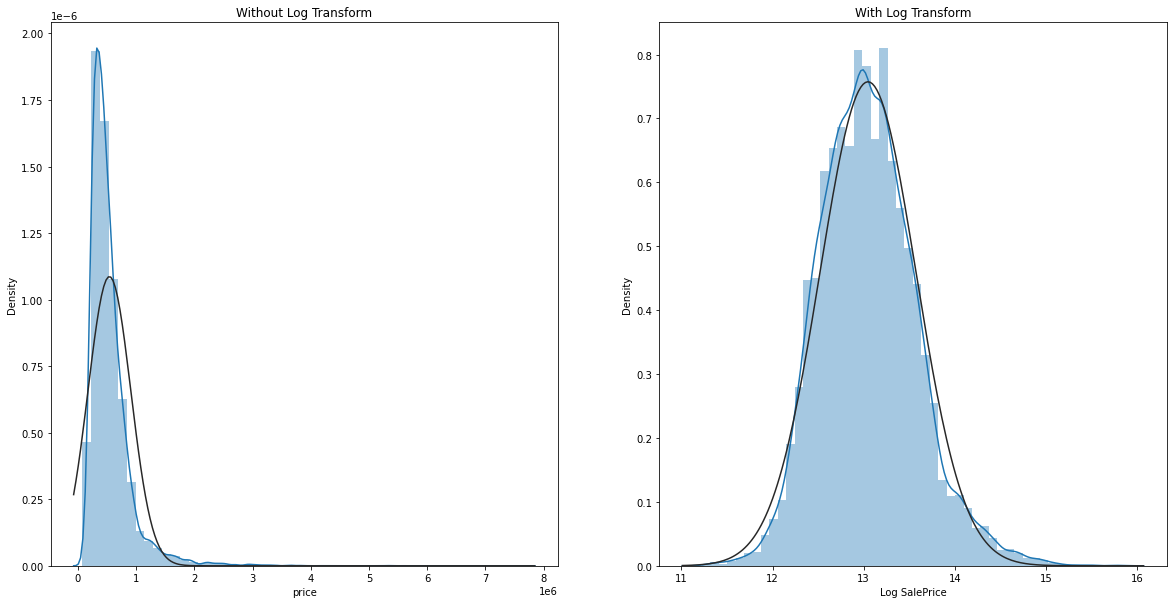

In [25]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.distplot(target, kde=True, fit=scipy.stats.norm)
plt.title("Without Log Transform")

plt.subplot(1, 2, 2)
sns.distplot(np.log(target), kde=True, fit=scipy.stats.norm)
plt.xlabel("Log SalePrice")
plt.title("With Log Transform")

plt.show()

In [26]:
log_target = np.log(target)

# Train Test Split

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(data4, log_target, test_size=0.3, random_state=0)

# Model Bulding with LightGBM

When checking for RMSE on the target, the log function has to be removed. 

In [29]:
baseline_model = LGBMRegressor(verbose = 0, force_row_wise = True)
_ = baseline_model.fit(X_train,y_train)

In [30]:
kf = KFold(n_splits=10)
results = cross_val_score(baseline_model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

In [31]:
# log(rmse) gotten from each cross_validation
-results

array([0.07619251, 0.08150696, 0.07517909, 0.08110846, 0.07476841,
       0.08352854, 0.07486541, 0.07647434, 0.07583522, 0.07768932])

<Figure size 1152x720 with 0 Axes>

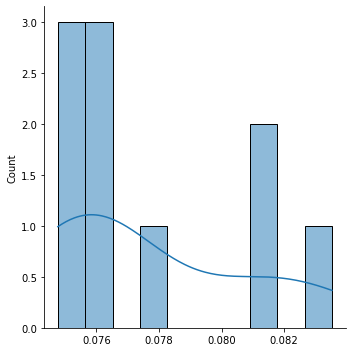

In [32]:
plt.figure(figsize=(16,10))

sns.displot(-results, bins=10, kde=True)

In [33]:
train_rmse = np.exp(np.sqrt(np.mean(-results)))
train_rmse

1.3215083730258967

# Predictions

In [34]:
predictions = baseline_model.predict(X_test)

In [35]:
test_rmse = np.exp(metrics.mean_squared_error(predictions, y_test))
test_rmse

1.077991750580343

## saving model 

In [36]:
import pickle

In [42]:
filename = 'prediction_model.sav'
pickle.dump(baseline_model, open(filename, 'wb'))

In [43]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(X_test)
print(np.exp(result))

[ 350344.75363225 1581783.99485641  483262.99631792 ...  341738.45451631
  278401.71007492  267893.74265663]


In [44]:

input_data = (3,2,2570,7242,2,0,0,3,7,2170,400,1951,1690,7639)

# changing the input_data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = loaded_model.predict(input_data_reshaped)


prediction = np.exp(prediction)

In [45]:
prediction

array([2359249.88308122])